**Here we explore how to inject confounding bias into binary classification problems. **

To do so, we consider a standard binary classification problem with feature matrix $X$ and labels $y$. We modify the training sample to inject a confounding bias.
- Select a feature $f$ that has low chi2 value and occurs at least $N$ times but no more than $M$ times.
- Sample a training set $D$ in which $f$ and $y$ have a specified correlation
- Plot test accuracy as correlation varies.

The experiments below classify 20 news group data ("pc" vs "mac). The plots below demonstrate that we have indeed injected a confounding bias and that it greatly influences the resulting classifier. In this example, the term "but" is confounded with the true class. We plot the learned coefficient with "but" against a highly predictive term ("mac") for comparison.

The trickiest part of this is the sampling routine (`make_confounding_data`). This must ensure that (a) the class distribution is the same across trials, (b) the selection bias is the same across trials (e.g., that the probability of the term "but" is constant as we vary confounding bias).

**Related work:**

- http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3117385/
- <ftp://learning.cs.toronto.edu/dist/gh/Hirst-etal-2010-JADT.pdf>

In [1]:
from collections import defaultdict
import copy
from itertools import combinations
import math
import numpy as np

import scipy.sparse as sparse
from scipy.stats import sem

from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import scale
from scipy.sparse import issparse

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# A matching-based classifier.
def make_same_length(a, b):
    # Duplicate the smaller list until it is at least as large as the larger list.
    if len(a) < len(b):
        factor = int(math.ceil(1. * len(b) / len(a)))
        a = a * factor
    else:
        factor = int(math.ceil(1. * len(a) / len(b)))
        b = b * factor
    return a, b        

    
def matching_sum(X, y, c, rand, feature_names):
    """
    For each training example where y=y_i and c=c_i, create a negative example equal to the mean
    feature value for y=y_i' and c=c_i.
    Training objective is to discriminate these pairs of examples.
    FIXME: this is slow.
    """
    both_pos = [i for i in range(len(y)) if y[i] == 1 and c[i] == 1]
    both_neg = [i for i in range(len(y)) if y[i] == 0 and c[i] == 0]
    ypos_cneg = [i for i in range(len(y)) if y[i] == 1 and c[i] == 0]
    yneg_cpos = [i for i in range(len(y)) if y[i] == 0 and c[i] == 1]

    both_pos_sum = X[both_pos, :].mean(axis=1)
    both_neg_sum = X[both_neg, :].mean(axis=1)
    ypos_cneg_sum = X[ypos_cneg, :].mean(axis=1)
    yneg_cpos_sum = X[yneg_cpos, :].mean(axis=1)

    rows = []
    newY = []
    flip = 1.
    for i in range(len(y)):
        if y[i] == 1:
            if c[i] == 1:
                rows.append((X[i] - yneg_cpos_sum) * flip)
                newY.append(max(int(flip), 0))
                flip *= -1
                #for j in yneg_cpos:
                #    if j > i:
                #        rows.append((X[i] - X[j]) * flip)
                #        newY.append(max(int(flip), 0))
                #        flip *= -1
            else:
                rows.append((X[i] - both_neg_sum) * flip)
                newY.append(max(int(flip), 0))
                flip *= -1                
                #for j in both_neg:
                #    if j > i:
                #        rows.append((X[i] - X[j]) * flip)
                #        newY.append(max(int(flip), 0))
                #        flip *= -1
        else:
            if c[i] == 1:
                rows.append((ypos_cneg_sum - X[i]) * flip)
                newY.append(max(int(flip), 0))
                flip *= -1                
                #for j in ypos_cneg:
                #    if j > i:
                #        rows.append((X[j] - X[i]) * flip)
                #        newY.append(max(int(flip), 0))
                #        flip *= -1
            else:
                rows.append((both_pos_sum - X[i]) * flip)
                newY.append(max(int(flip), 0))
                flip *= -1                                
                #for j in both_pos:
                #    if j > i:
                #        rows.append((X[j] - X[i]) * flip)
                #        newY.append(max(int(flip), 0))
                #        flip *= -1
                    
    newX = sparse.vstack(rows)
    m = LogisticRegression(fit_intercept=False)
    print('fit on %d instances' % newX.shape[0])
    m.fit(newX, newY)
    return m                

In [3]:
def matching(X, y, c, rand, feature_names):
    """
    For each training example where y=y_i and c=c_i, create a negative example by sampling 
    an instance where y!=y_i and c=c_i
    Training objective is to discriminate these pairs of examples.
    FIXME: accuracy is pretty low. Is it because p(c) is biases in the sampling method?
    """
    both_pos = [i for i in range(len(y)) if y[i] == 1 and c[i] == 1]
    both_neg = [i for i in range(len(y)) if y[i] == 0 and c[i] == 0]
    ypos_cneg = [i for i in range(len(y)) if y[i] == 1 and c[i] == 0]
    yneg_cpos = [i for i in range(len(y)) if y[i] == 0 and c[i] == 1]

    rows = []
    newY = []
    flip = 1.
    for i in range(len(y)):
        if y[i] == 1:
            if c[i] == 1:
                fv = X[i] - X[rand.choice(yneg_cpos)]
            else:
                fv = X[i] - X[rand.choice(both_neg)]
        else:
            if c[i] == 1:
                fv = X[rand.choice(ypos_cneg)] - X[i]
            else:
                fv = X[rand.choice(both_pos)] - X[i]
            
        rows.append(fv * flip)
        newY.append(max(int(flip), 0))
        flip *= -1
                    
    newX = sparse.vstack(rows)
    m = LogisticRegression(fit_intercept=False)
    m.fit(newX, newY)
    return m    

In [4]:
# Sum out the confounding variable.
# 1. Fit classifier in product space of c/y. (E.g., P(c^y|x))
# 2. To classify new x, return P(c=1^y=1|x) + P(c=0^y=1|x)
class SumOutClf:
    def __init__(self, clf):
        self.clf = clf
        self.coef_ = [self.clf.coef_[2]]
        
    def predict(self, X):
        proba = np.matrix(self.clf.predict_proba(X))
        # sum cols 1,2 (y0c0, y0c1) and cols 3,4 (y1c0,y1c1)
        proba = np.hstack((proba[:,:2].sum(axis=1), proba[:,2:4].sum(axis=1)))
        # return argmax of each row
        return np.array(proba.argmax(axis=1).T.tolist()[0])
        
def sumout(X, y, c, rand, feature_names):
    clf = LogisticRegression()
    label2index = {(0, 0): 0, (0, 1): 1, (1, 0): 2, (1, 1): 3}
    yc = [label2index[(yi, ci)] for yi, ci in zip(y, c)]
    clf.fit(X, yc)
    return SumOutClf(clf)

c = sumout([[1,1],[1,0],[0,1],[0,0]], [1,1,0,0], [1,0,1,0], None, None)
print(c.predict([[1,1],[1,0],[0,1],[0,0]]))
print(c.coef_[0])

[1 1 0 0]
[ 0.2334584  -0.58200704]


In [5]:
# Implement the backdoor adjustment on the confouding variable
# 1. Fit classifier on P(y|x,z)
# 2. To classify new x, return P(y=1|x,z=0)*P(z=0) + P(y=1|x,z=1)*P(z=1)

class BackdoorAdjustmentClf:
    def __init__(self, clf):
        self.clf = clf
        self.coef_ = self.clf.coef_
        self.c_prob = []
        self.c_values = []

    def predict(self, X):
        if issparse(X):
            X = X.toarray()   
        X = np.array(X)
        # build features with every possible confounder
        l = len(self.c_values)
        c = np.array(self.c_values).reshape(-1,1)
        c = np.tile(c, (len(X), 1))
        # build the probabilities to be multiplied by
        p = np.array(self.c_prob).reshape(-1,1)
        p = np.tile(p, (len(X), 1))
        # combine the original features and the possible confounder values
        X = np.repeat(X,2,axis=0)
        Xc = np.hstack((X,c))
        proba = np.matrix(self.clf.predict_proba(Xc))
        # multiply by P(z) and sum over the confounder for every instance in X
        proba = np.array(proba)
        proba *= p
        proba = proba.reshape(-1, l, 2)
        proba = np.sum(proba, axis=1)
        # normalize
        proba /= l
        return np.array(proba.argmax(axis=1))

def backdoor_adjustment(X, y, c, rand, feature_names):
    if issparse(X):
        X = X.toarray()
    clf = LogisticRegression()
    Xc = np.hstack((X, np.array(c).reshape(-1,1)))
    clf.fit(Xc, y)
    c_values = sorted(list(set(c)))
    c_prob = []
    for cv in c_values:
        c_prob.append(1.*len(np.where(np.array(c) == cv)[0])/len(c))
    clf_backdoor_adj = BackdoorAdjustmentClf(clf)
    clf_backdoor_adj.c_prob = c_prob
    clf_backdoor_adj.c_values = c_values
    return clf_backdoor_adj

c = backdoor_adjustment([[1,1],[1,0],[0,1],[0,0]], [1,1,0,0], [1,0,1,0], None, None)
print(c.predict([[1,1],[1,0],[0,1],[0,0]]))
print(c.coef_[0])

[1 1 0 0]
[ 0.74034023 -0.05264216 -0.05264216]


In [10]:
# Implement the backdoor adjustment from the observation of up to ten features
class BackdoorAdjustmentFromObservationsClf:
    def __init__(self, clf, obs_var_idx=[], o_cond_probs=[], o_space=[]):
        self.clf = clf
        self.coef_ = self.clf.coef_
        self.obs_var_idx = obs_var_idx
        self.o_cond_probs = o_cond_probs
        self.o_space = o_space
        self.inverts = [np.linalg.inv(np.matrix(cp)) for cp in self.o_cond_probs]
        print(self.inverts)
    
    def predict(self, X):
        if issparse(X):
            X = X.toarray()   
        X = np.array(X)
        # build features with every possible confounder
        l = len(self.c_values)
        c = np.array(self.c_values).reshape(-1,1)
        c = np.tile(c, (len(X), 1))
        # build the probabilities to be multiplied by
        p = np.array(self.c_prob).reshape(-1,1)
        p = np.tile(p, (len(X), 1))
        # combine the original features and the possible confounder values
        X = np.repeat(X,2,axis=0)
        Xc = np.hstack((X,c))
        proba = np.matrix(self.clf.predict_proba(Xc))
        # multiply by P(z) and sum over the confounder for every instance in X
        proba = np.array(proba)
        proba *= p
        proba = proba.reshape(-1, l, 2)
        proba = np.sum(proba, axis=1)
        # normalize
        proba /= l
        return np.array(proba.argmax(axis=1))

def find_n_top_features(X, c, feature_names, n=2):
    """ Find the highest chi2 feature and return the indices of these features."""
    if type(X) is list:
        X = np.array(X)
    chi, F = chi2(X, c)
    clf = LogisticRegression()
    clf.fit(X, c)
    coef_sign = clf.coef_[0] / np.abs(clf.coef_[0])
    signed_chi = chi * coef_sign
    counts = X.sum(0).tolist()
    top_feats = [i for i in np.argsort(signed_chi)[::-1] if counts[i] > 1][:n]
    if feature_names is not None:
        print('top_feats=', feature_names[top_feats])
    return top_feats

def backdoor_adjustment_from_observations(X, y, c, rand, feature_names, n=2):
    if issparse(X):
        X = X.toarray()
    obs_vars_idx = find_n_top_features(X, c, feature_names, n)
    clf = LogisticRegression()
    o_spaces = []
    o_cond_probs = []
    
    # Get the space of the confounder
    c_space = list(set(c))
    c = np.array(c)
    
    # Get informations about every observed variable (conditional probability and dimension)
    for idx in obs_vars_idx:
        # Get the space of the observed variable
        o_values = X[:, idx]
        o_space = list(set(o_values))
        o_spaces.append(o_space)
        # Build the conditional probabilities p(w|c)
        cond_prob = np.zeros((len(o_space), len(c_space)))
        for cv in c_space:
            cv_where = np.where(np.array(c) == cv)[0]
            for ov in o_space:
                ov_where = np.where(np.array(o_values) == ov)[0]
                intersection_ov_cv = set(ov_where) & set(cv_where)
                cond_prob[ov, cv] = 1.*len(intersection_ov_cv)/len(o_values)
        o_cond_probs.append(cond_prob)
    
    # add the observed variables as features
    Xc = np.hstack([X] + [X[:,obs_vars_idx]])
    print(Xc.shape)
    clf.fit(Xc, y)
    return BackdoorAdjustmentFromObservationsClf(clf, obs_vars_idx, o_cond_probs, o_space)

c = backdoor_adjustment([[1,1],[1,0],[0,1],[0,0]], [1,1,0,0], [1,0,1,0], None, None)
print(c.predict([[1,1],[1,0],[0,1],[0,0]]))
print( c.coef_[0])

[1 1 0 0]
[ 0.74034023 -0.05264216 -0.05264216]


In [20]:
def feature_select(X, y, c, rand, feature_names):
    """ Find the highest chi2 feature for class c and remove it from the classifier."""
    chi, F = chi2(X, c)
    clf = LogisticRegression()
    clf.fit(X, c)
    coef_sign = clf.coef_[0] / np.abs(clf.coef_[0])
    signed_chi = chi * coef_sign
    counts = X.sum(0).tolist()[0]
    top_feats = [i for i in np.argsort(signed_chi)[::-1] if counts[i] > 1][:1]
    if feature_names is not None:
        print('top_feats=', feature_names[top_feats])
    X2 = copy.copy(X)
    X2[:,top_feats] = 0.  # Set top feature to 0
    clf.fit(X2, y)
    return clf

c = feature_select(np.matrix([[1,1],[1,0],[0,1],[0,0]]), [1,1,0,0], [1,0,1,0], None, None)
print(c.predict([[1,1],[1,0],[0,1],[0,0]]))
print(c.coef_[0])

[1 1 0 0]
[ 0.73101554  0.        ]


In [21]:
from collections import Counter
import numpy as np
from scipy.stats import pearsonr

def make_confounding_data(X, y, c, pos_prob, bias, size, rand):
    """ Create Sample a dataset of given size where c is a confounder for y with strenght=bias.
        We take care not to introduce selection bias (that is, p(c=1) is representative of training data).
        This assumes that #[c=1] < #[y=1].
        
        X: data matrix
        y: labels (0, 1)
        c: confounding lables (0,1)
        pos_prop: proportion of instances where y=1
        bias: amount of bias (0-1)
        size: number of samples
        rand: RandomState
    """
    both_pos = [i for i in range(len(y)) if y[i] == 1 and c[i] == 1]
    both_neg = [i for i in range(len(y)) if y[i] == 0 and c[i] == 0]
    ypos_cneg = [i for i in range(len(y)) if y[i] == 1 and c[i] == 0]
    yneg_cpos = [i for i in range(len(y)) if y[i] == 0 and c[i] == 1]
    for x in [both_pos, both_neg, yneg_cpos, ypos_cneg]:
        rand.shuffle(x)

    # if bias=.9, then 90% of instances where c=1 will also have y=1
    # similarly, 10% of instances where c=1 will have y=0
    cprob = 1. * sum(c) / len(c)
    n_cpos = int(cprob * size)
    n_cneg = size - n_cpos
    n_ypos = int(pos_prob * size)    
    n_yneg = size - n_ypos
    n_11 = int(bias * n_cpos)
    n_01 = int((1 - bias) * n_cpos)
    n_10 = n_ypos - n_11
    n_00 = n_yneg - n_01    
    
    return np.array(both_pos[:n_11] + both_neg[:n_00] + ypos_cneg[:n_10] + yneg_cpos[:n_01])
    return sample

In [22]:
def find_confounder(X, y, feature_names, rand):
    """ Find a confounding feature, defined as one that appears frequently but has low chi2 value.
    X ..............Binary feature matrix
    y ..............true labels
    feature_names...list of feature names
    rand............Random state
    
    Returns:
    confounding_feature_index....index of the confounding feature
    best_feature_index...........index of feature with strongest chi2 (for comparison)
    labels.......................binary labels for the confounding feature (i.e., 1 if instance has term, 0 otherwise)
    """
    chi, p = chi2(X, y)
    counts = X.sum(0).tolist()[0]
    picked = -1
    l_thresh = len(y) * .30  # confounder must occur in at least 30% of instances.
    u_thresh = len(y) * .40  # confounder must occur in at most 40% of instances.
    for i in np.argsort(chi):
        if counts[i] > l_thresh and counts[i] < u_thresh:
            picked = i
            break
    c = np.array([1 if X[row, picked] else 0 for row in range(len(y))])
    print('picked confounding feature=', feature_names[picked], 'index=', picked, 'corr=', pearsonr(y, c)[0], 'chi=', chi[i], 'count=', counts[i])
    return picked, np.array([1 if X[row, picked] else 0 for row in range(len(y))])

def find_confounder_by_cluster(X, y, feature_names, rand):
    """ Find a confounding feature, defined as ...
    X ..............Binary feature matrix
    y ..............true labels
    feature_names...list of feature names
    rand............Random state
    
    Returns:
    confounding_feature_index....index of the confounding feature
    best_feature_index...........index of feature with strongest chi2 (for comparison)
    labels.......................binary labels for the confounding feature (i.e., 1 if instance has term, 0 otherwise)
    """
    n_clust = 10
    clusterer = KMeans(n_clusters=n_clust, init='random', n_init=10, random_state=rand)
    clusters = clusterer.fit_predict(TfidfTransformer().fit_transform(X))
    for cid in range(n_clust):
        labels = [1 if c==cid else 0 for c in clusters]
        corr = pearsonr(labels, y)[0]
        print('corr=', corr, 'size=', sum(labels))
        if abs(corr) < .3 and sum(labels) > .1 * len(y) and sum(labels) < .5 * len(y):
            print('picking cluster %d size=%d corr=%g' % (cid, sum(labels), corr))
            chi, F = chi2(X, labels)
            top_feats = np.argsort(chi)
            print('top features=%s' % (feature_names[top_feats[-10:]]))
            return top_feats[-1], np.array(labels)
    print('cant find good cluster')

In [26]:
def plot_coef(all_coef, all_corrs, confounding_feature, feature_names):
    # Plot learned coefficients as correlation varies.
    plt.figure()
    colors = ['k', 'r', 'b', 'g', 'c']
    for ci, name in enumerate(all_coef):
        coef = all_coef[name]
        corrs = all_corrs[name]
        coef_means = [np.mean(x) for x in coef]
        plt.errorbar(corrs, coef_means, yerr=[sem(x) for x in coef],
                     fmt=colors[ci] + 'o', label=name + '_' + feature_names[confounding_feature])
    plt.ylabel('coefficient (standardized)')
    plt.xlabel('correlation(y, c)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=len(all_corrs))
    plt.show()

      
def plot_accuracies(all_accuracies, all_corrs):
    # Plot accuracies as correlation varies.
    plt.figure()
    colors = ['k', 'r', 'b', 'g', 'c']
    for ci, name in enumerate(all_accuracies):
        accuracies = all_accuracies[name]
        corrs = all_corrs[name]
        acc_means = [np.mean(x) for x in accuracies]
        plt.errorbar(corrs, acc_means, yerr=[sem(x) for x in accuracies],
                     fmt=colors[ci] + 'o', label=str(name))
    plt.xlabel('correlation(y, c)')
    plt.ylabel('accuracy')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=len(all_accuracies))
    plt.show()

def do_confounding_trials(models, X_train, y_train, X_test, y_test,
                          feature_names, confounding_feature, confounding_labels,
                          ntrials, rand):  
    """ Do several random trials in which we sample data with a confounding variable. 
    Plot the average accuracies as confounding bias increases.
    """

    # biases = [0, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, 1.]
    biases = [.1, .2, .3, .4, .5, .6, .7, .8, .9,]
    # biases = [.1, .5, .9]
    coef = defaultdict(lambda: np.zeros((len(biases), ntrials)))
    corrs = defaultdict(lambda: np.zeros(len(biases)))
    accuracies = defaultdict(lambda: np.zeros((len(biases), ntrials)))
    for bi, bias in enumerate(biases):
        n_11 = 0
        n_c1 = 0
        for ti in range(ntrials):
            train_idx = make_confounding_data(X=X_train, y=y_train, c=confounding_labels,
                                              pos_prob=.5, bias=bias, size=500, rand=rand)    
            n_11 = len([yi for yi, ci in zip(y_train[train_idx], confounding_labels[train_idx]) if yi==1 and ci==1])
            n_c1 = sum(confounding_labels[train_idx])
            for name, model in models:
                clf = model(X_train[train_idx], y_train[train_idx],
                            confounding_labels[train_idx], rand, feature_names)
                pred = clf.predict(X_test)
                coef[name][bi, ti] = scale(clf.coef_[0])[confounding_feature]
                corrs[name][bi] = pearsonr(y_train[train_idx], confounding_labels[train_idx])[0]
                accuracies[name][bi, ti] = accuracy_score(y_test, clf.predict(X_test))
        print('bias=', bias, 'corr(y,c)=', list(corrs.values())[0][bi], 'num[y=1,c=1]=', n_11, 'num[c=1]=', n_c1)

    plot_coef(coef, corrs, confounding_feature, feature_names)
    plot_accuracies(accuracies, corrs)


## 20 Newsgroups Experiments

In [24]:
def lr(X, y, c, rand, feature_names):
    clf = LogisticRegression()
    clf.fit(X, y)
    return clf

def nb(X, y, c, rand, feature_names):
    clf = BernoulliNB()
    clf.fit(X, y)
    return clf


def do_newsgroups_expt(categories):
    rand = np.random.RandomState(1234567)
    ntrials = 10
    newsgroups_train = fetch_20newsgroups(subset='train',
                                          remove=('headers', 'footers', 'quotes'),
                                          categories=categories)
    newsgroups_test = fetch_20newsgroups(subset='test',
                                         remove=('headers', 'footers', 'quotes'),
                                         categories=categories)
    vectorizer = CountVectorizer(binary=True)
    X_train = vectorizer.fit_transform(newsgroups_train.data)
    y_train = newsgroups_train.target
    X_test = vectorizer.transform(newsgroups_test.data)
    y_test = newsgroups_test.target
    print('train size=', len(y_train), 'test size=', len(y_test))
    feature_names = np.array(vectorizer.get_feature_names())
    # models = [('logreg', lr), ('nb', nb), ('matching', matching), ('sumout', sumout)]
    # models = [('logreg', lr), ('feature_select', feature_select), ('matching', matching)]
    # models = [('logreg', lr), ('feature_select', feature_select), ('matching', matching)]
    models = [('logreg', lr), ('feature_select', feature_select), ('matching', matching), ('backdoor_adjustment', backdoor_adjustment)]

    print('----------------\nExperiments using a single feature confounder:')
    confounding_feature, confounding_labels = find_confounder(X_train, y_train, feature_names, rand)
    do_confounding_trials(models, X_train, y_train, X_test, y_test, feature_names,
                          confounding_feature, confounding_labels, ntrials, rand)

    print('----------------\nExperiments using a cluster as confounder:')
    confounding_feature, confounding_labels = find_confounder_by_cluster(X_train, y_train, feature_names, rand)
    do_confounding_trials(models, X_train, y_train, X_test, y_test, feature_names,
                          confounding_feature, confounding_labels, ntrials, rand)

train size= 1168 test size= 777
----------------
Experiments using a single feature confounder:
picked confounding feature= but index= 2724 corr= -0.000644430370544 chi= 0.000297763290278 count= 451
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
bias= 0.1 corr(y,c)= -0.633278506399 num[y=1,c=1]= 19 num[c=1]= 192
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
bias= 0.2 corr(y,c)= -0.477014978846 num[y=1,c=1]= 38 num[c=1]= 192
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
top_feats= ['but']
bias= 0.3 corr(y,c)= -0.320751451293 num[y=1,c=1]= 57 num[c=1]= 192
top_feats= ['but']
top_feat

/usr/lib64/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:161: RuntimeWarning: invalid value encountered in true_divide
  chisq /= f_exp
/usr/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/usr/lib64/python3.4/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


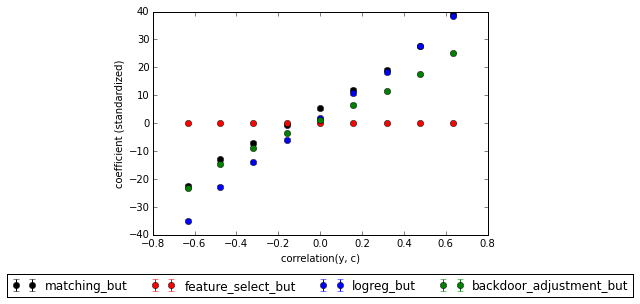

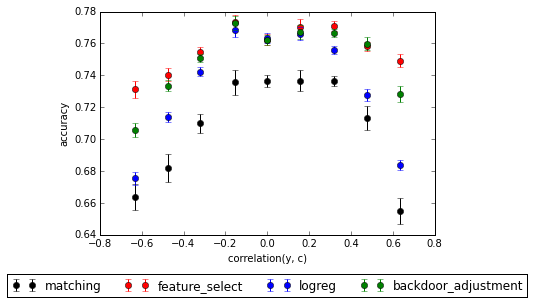

----------------
Experiments using a cluster as confounder:
corr= -0.168914057083 size= 103
corr= -0.0195010000913 size= 145
picking cluster 1 size=145 corr=-0.019501
top features=['where' 'jim' 'buying' 'trinitron' 'tube' 'quality' 'cwru' 'po' 't560i'
 'price']
top_feats= ['net']
top_feats= ['t560i']
top_feats= ['t560i']
top_feats= ['t560i']
top_feats= ['t560i']
top_feats= ['t560i']
top_feats= ['trinitron']
top_feats= ['t560i']
top_feats= ['trinitron']
top_feats= ['t560i']
bias= 0.1 corr(y,c)= -0.299432476626 num[y=1,c=1]= 6 num[c=1]= 61
top_feats= ['t560i']
top_feats= ['t560i']
top_feats= ['t560i']
top_feats= ['t560i']
top_feats= ['tube']
top_feats= ['price']
top_feats= ['t560i']
top_feats= ['t560i']
top_feats= ['t560i']
top_feats= ['quality']
bias= 0.2 corr(y,c)= -0.226102074187 num[y=1,c=1]= 12 num[c=1]= 61
top_feats= ['price']
top_feats= ['t560i']
top_feats= ['price']
top_feats= ['quality']
top_feats= ['trinitron']
top_feats= ['source']
top_feats= ['t560i']
top_feats= ['tube']
top

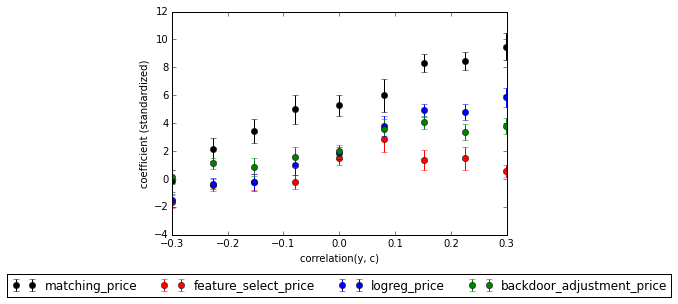

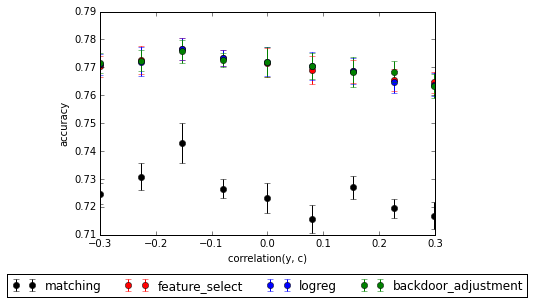

In [27]:
do_newsgroups_expt(['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'])

train size= 1177 test size= 784
----------------
Experiments using a single feature confounder:
picked confounding feature= are index= 2617 corr= 0.00558739245899 chi= 0.0248190688202 count= 382
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
bias= 0.1 corr(y,c)= -0.552175233096 num[y=1,c=1]= 16 num[c=1]= 161
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
bias= 0.2 corr(y,c)= -0.415201531863 num[y=1,c=1]= 32 num[c=1]= 161
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
top_feats= ['are']
bias= 0.3 corr(y,c)= -0.27822783063 num[y=1,c=1]= 48 num[c=1]= 161
top_feats= ['are']
top_feats= ['

/usr/lib64/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:161: RuntimeWarning: invalid value encountered in true_divide
  chisq /= f_exp
/usr/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/usr/lib64/python3.4/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


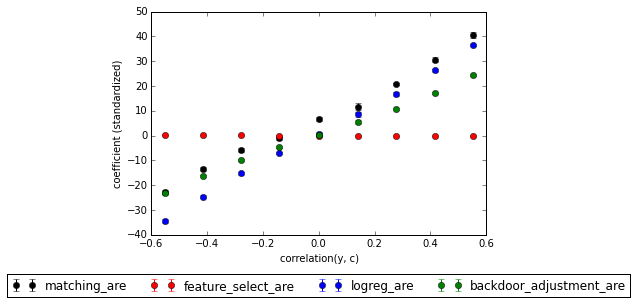

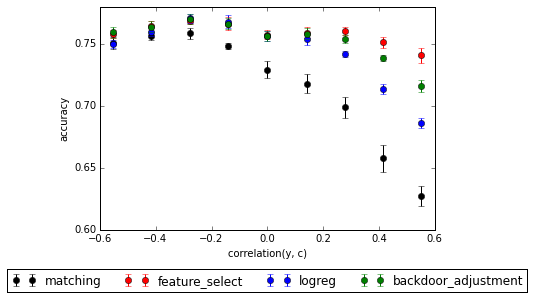

----------------
Experiments using a cluster as confounder:
corr= -0.0767108597154 size= 30
corr= 0.369243787779 size= 189
corr= -0.0280974661297 size= 117
corr= -0.148981760379 size= 252
picking cluster 3 size=252 corr=-0.148982
top features=['help' 'does' 'hi' 'please' 'am' 'anyone' 'some' 'would' 'thanks' 'any']
top_feats= ['temp']
top_feats= ['stone']
top_feats= ['computer']
top_feats= ['temp']
top_feats= ['sorry']
top_feats= ['companies']
top_feats= ['canberra']
top_feats= ['north']
top_feats= ['image']
top_feats= ['sorry']
bias= 0.1 corr(y,c)= -0.420821003539 num[y=1,c=1]= 10 num[c=1]= 106
top_feats= ['computer']
top_feats= ['generation']
top_feats= ['computer']
top_feats= ['computer']
top_feats= ['told']
top_feats= ['verlag']
top_feats= ['computer']
top_feats= ['image']
top_feats= ['wouldn']
top_feats= ['computer']
bias= 0.2 corr(y,c)= -0.313169118913 num[y=1,c=1]= 21 num[c=1]= 106
top_feats= ['france']
top_feats= ['newspaper']
top_feats= ['north']
top_feats= ['senior']
top_feat

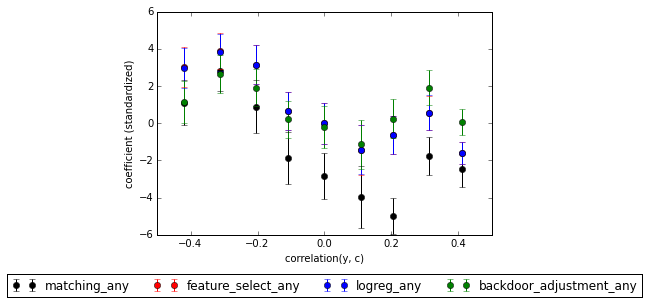

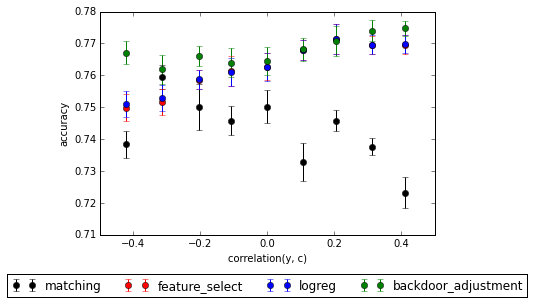

In [28]:
do_newsgroups_expt(['comp.graphics', 'comp.windows.x'])

train size= 1186 test size= 789
----------------
Experiments using a single feature confounder:
picked confounding feature= there index= 16683 corr= -0.041334402255 chi= 1.39074570716 count= 372
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
bias= 0.1 corr(y,c)= -0.540548437581 num[y=1,c=1]= 15 num[c=1]= 155
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
bias= 0.2 corr(y,c)= -0.40216803756 num[y=1,c=1]= 31 num[c=1]= 155
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
top_feats= ['there']
bias= 0.3 corr(y,c)= -0.272436412541 num

/usr/lib64/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:161: RuntimeWarning: invalid value encountered in true_divide
  chisq /= f_exp
/usr/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
/usr/lib64/python3.4/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


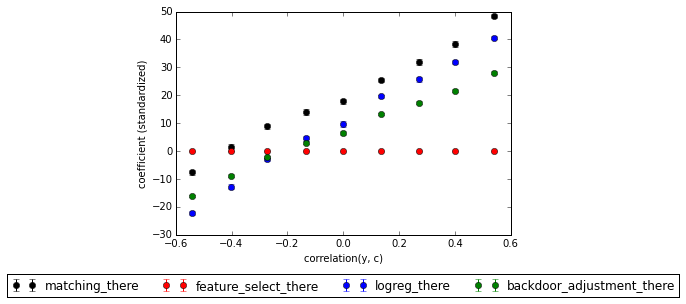

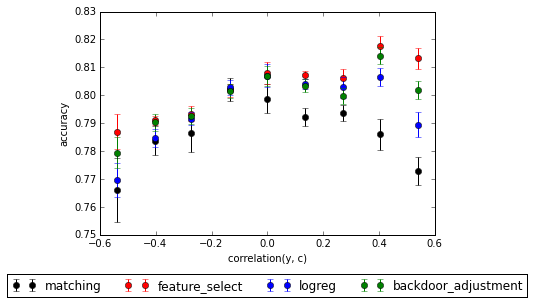

----------------
Experiments using a cluster as confounder:
corr= -0.0490874124463 size= 290
picking cluster 0 size=290 corr=-0.0490874
top features=['public' 'forth' 'message' 'damn' 'encrypted' 'key' 'did' 'encryption'
 'ahead' 'keys']
top_feats= ['clinton']
top_feats= ['clinton']
top_feats= ['did']
top_feats= ['us']
top_feats= ['clinton']
top_feats= ['clinton']
top_feats= ['damn']
top_feats= ['bush']
top_feats= ['did']
top_feats= ['our']
bias= 0.1 corr(y,c)= -0.452959574572 num[y=1,c=1]= 12 num[c=1]= 121
top_feats= ['clinton']
top_feats= ['clinton']
top_feats= ['ahead']
top_feats= ['did']
top_feats= ['clinton']
top_feats= ['did']
top_feats= ['took']
top_feats= ['bush']
top_feats= ['took']
top_feats= ['clinton']
bias= 0.2 corr(y,c)= -0.340887102513 num[y=1,c=1]= 24 num[c=1]= 121
top_feats= ['quite']
top_feats= ['us']
top_feats= ['ahead']
top_feats= ['us']
top_feats= ['did']
top_feats= ['clinton']
top_feats= ['us']
top_feats= ['our']
top_feats= ['ahead']
top_feats= ['did']
bias= 0.3 c

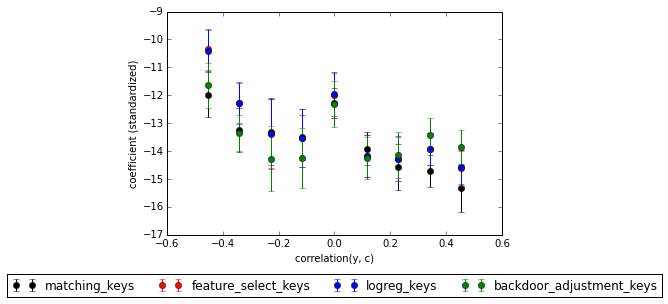

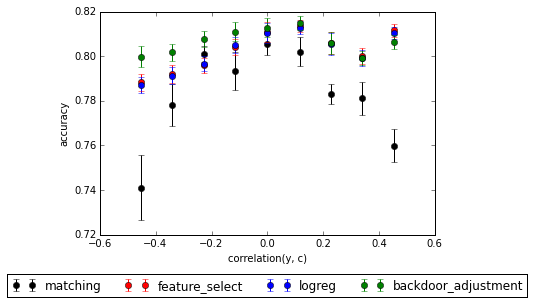

In [29]:
do_newsgroups_expt(['sci.crypt', 'sci.electronics'])